#### Trained locally

## Fine tuning BERT for sentiment analysis on hotel reviews

In [1]:
# import required packages

import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils import data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

## Data exploration and preprocessing

In [2]:
# load dataset

df = pd.read_csv("../data/tripadvisor_hotel_reviews.csv")
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [3]:
# rename column to lowercase

df.rename(columns={"Review": "review", "Rating": "rating"}, inplace=True)

In [4]:
# view column names and row counts

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  20491 non-null  object
 1   rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


<BarContainer object of 5 artists>

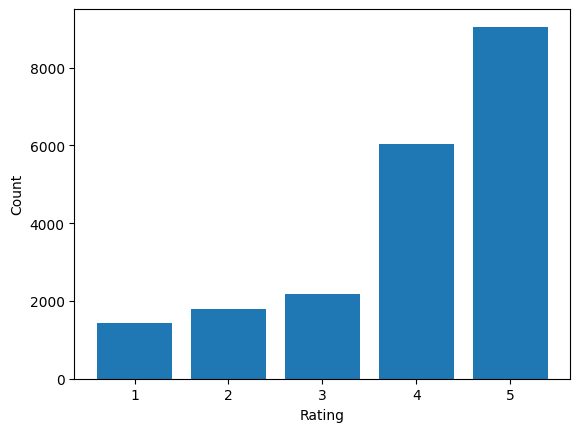

In [5]:
# check rating distribution

count = df.rating.value_counts()
plt.xlabel("Rating")
plt.ylabel("Count")
plt.bar(count.index, count.values)

In [6]:
# create a new column sentiment based on rating

def sentiment(rating):
    if rating < 3:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

df["sentiment"] = df.rating.apply(sentiment)
df

,review,rating,sentiment
0,nice hotel expensive parking got good deal sta...,4,2
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,1
3,"unique, great stay, wonderful time hotel monac...",5,2
4,"great stay great stay, went seahawk game aweso...",5,2
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,2
20487,great location price view hotel great quick pl...,4,2
20488,"ok just looks nice modern outside, desk staff ...",2,0
20489,hotel theft ruined vacation hotel opened sept ...,1,0


<Axes: xlabel='sentiment'>

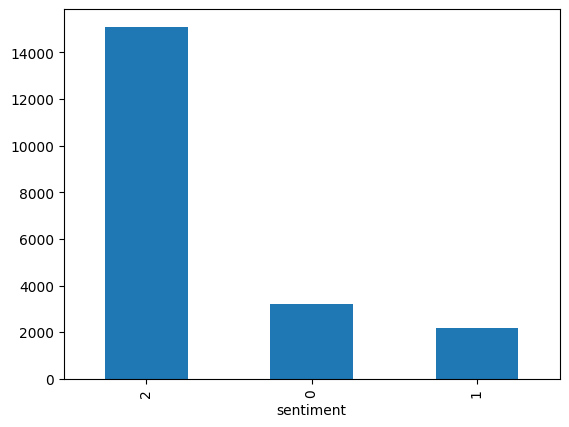

In [7]:
# check sentiment distribution

df.sentiment.value_counts().plot.bar()

In [8]:
# balance the classes using an undersampler

from imblearn.under_sampling import RandomUnderSampler

X = df.drop("sentiment", axis=1)
y = df["sentiment"]

undersampler = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = undersampler.fit_resample(X, y)

resampled_df = X_resampled
resampled_df["sentiment"] = y_resampled

In [9]:
resampled_df

,review,rating,sentiment
2691,beautiful grounds hospitality lacking admit hi...,2,0
15099,great location average service picked hotel lo...,2,0
1945,"not think expected pampered, doing constructio...",1,0
6180,rated 5.5 1-10 scale start pros 1. street waik...,2,0
14188,"save money, friend came resort week staff unfr...",2,0
...,...,...,...
6334,fine hotel fine location bargain price looking...,4,2
8630,great location daughter booked hotel surprise ...,5,2
19074,great hotel spent days melia hotel berlin fant...,5,2
16812,wonderful experience 24-year old daughter just...,5,2


<Axes: xlabel='sentiment'>

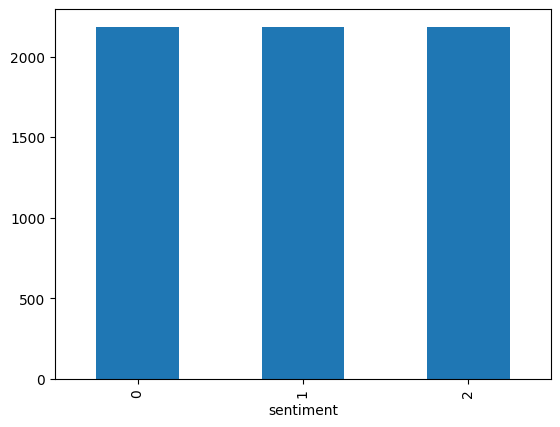

In [10]:
# check the resampled dataframe

resampled_df.sentiment.value_counts().plot.bar()

In [11]:
# reassign df to the resampled df 

df = resampled_df
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6552 entries, 2691 to 373
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     6552 non-null   object
 1   rating     6552 non-null   int64 
 2   sentiment  6552 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 204.8+ KB


In [12]:
# define bert model, tokenizer and labels

labels = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3, id2label=labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# count the number of tokens in each review

token_lens = []

for review in df.review:
    tokens = tokenizer(
        review,
        max_length=512,
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=False
    )
    token_lens.append(len(tokens["input_ids"]))

(array([ 49., 154., 267., 367., 427., 429., 426., 412., 387., 382., 355.,
        274., 273., 220., 198., 190., 167., 116., 116., 117., 100.,  89.,
         87.,  68.,  71.,  51.,  61.,  56.,  48.,  39.,  29.,  34.,  37.,
         26.,  36.,  26.,  22.,  17.,  17.,  14.,  18.,   9.,  11.,  13.,
         11.,  12.,  10.,   8.,   9., 197.]),
 array([ 12.,  22.,  32.,  42.,  52.,  62.,  72.,  82.,  92., 102., 112.,
        122., 132., 142., 152., 162., 172., 182., 192., 202., 212., 222.,
        232., 242., 252., 262., 272., 282., 292., 302., 312., 322., 332.,
        342., 352., 362., 372., 382., 392., 402., 412., 422., 432., 442.,
        452., 462., 472., 482., 492., 502., 512.]),
 <BarContainer object of 50 artists>)

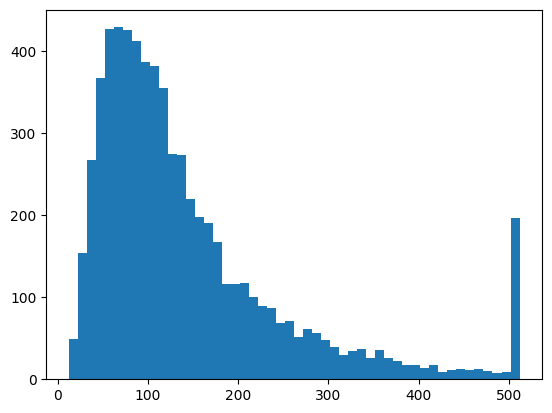

In [14]:
# plot token length distribution

plt.hist(token_lens, bins=50)

In [15]:
# split df into train, val and test datasets

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)

train_df.shape, val_df.shape, test_df.shape

((5241, 3), (656, 3), (655, 3))

In [16]:
# define class to create pytorch dataset

class HotelDataset(data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        review = str(self.df.iloc[index]["review"])
        sentiment = int(self.df.iloc[index]["sentiment"])

        encoding = self.tokenizer(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(sentiment, dtype=torch.long)
        }


## Training

In [17]:
# check if gpu is available for training

torch.cuda.is_available()

True

In [18]:
# training arguments

MAX_LEN = 128  
BATCH_SIZE = 8 
EPOCHS = 5      

In [19]:
# create dataset class instances

train_dataset = HotelDataset(train_df, tokenizer, MAX_LEN)
test_dataset = HotelDataset(test_df, tokenizer, MAX_LEN)
val_dataset = HotelDataset(val_df, tokenizer, MAX_LEN)


In [20]:
# define function for validation metrics

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, support = precision_recall_fscore_support(
        labels,
        preds,
        average="weighted"
    ) 
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [21]:
# define training arguments

training_args = TrainingArguments(
    output_dir="../models/local-checkpoints",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy="epoch",
    save_strategy="no",
    weight_decay=0.01,
    learning_rate=2e-5
    
)

In [22]:
# define trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

c:\Users\insha\Desktop\ML\mein task\venv\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [23]:
# train the model

trainer.train()

  0%|          | 0/3280 [00:00<?, ?it/s]

{'loss': 0.7251, 'grad_norm': 9.799237251281738, 'learning_rate': 1.6951219512195124e-05, 'epoch': 0.76}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.5689918994903564, 'eval_accuracy': 0.7667682926829268, 'eval_precision': 0.7657546503242543, 'eval_recall': 0.7667682926829268, 'eval_f1': 0.7660197073258456, 'eval_runtime': 11.7685, 'eval_samples_per_second': 55.742, 'eval_steps_per_second': 6.968, 'epoch': 1.0}
{'loss': 0.5044, 'grad_norm': 14.744300842285156, 'learning_rate': 1.3902439024390244e-05, 'epoch': 1.52}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.6195695996284485, 'eval_accuracy': 0.7820121951219512, 'eval_precision': 0.7790183078171541, 'eval_recall': 0.7820121951219512, 'eval_f1': 0.7791272351259919, 'eval_runtime': 11.7992, 'eval_samples_per_second': 55.597, 'eval_steps_per_second': 6.95, 'epoch': 2.0}
{'loss': 0.416, 'grad_norm': 24.047893524169922, 'learning_rate': 1.0853658536585368e-05, 'epoch': 2.29}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.8138575553894043, 'eval_accuracy': 0.7576219512195121, 'eval_precision': 0.7549414661344824, 'eval_recall': 0.7576219512195121, 'eval_f1': 0.7545336110829157, 'eval_runtime': 11.7956, 'eval_samples_per_second': 55.614, 'eval_steps_per_second': 6.952, 'epoch': 3.0}
{'loss': 0.3136, 'grad_norm': 22.403793334960938, 'learning_rate': 7.804878048780489e-06, 'epoch': 3.05}
{'loss': 0.1895, 'grad_norm': 43.40092849731445, 'learning_rate': 4.75609756097561e-06, 'epoch': 3.81}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 1.1520285606384277, 'eval_accuracy': 0.7698170731707317, 'eval_precision': 0.7678712393547255, 'eval_recall': 0.7698170731707317, 'eval_f1': 0.7685014212882907, 'eval_runtime': 11.7892, 'eval_samples_per_second': 55.644, 'eval_steps_per_second': 6.956, 'epoch': 4.0}
{'loss': 0.1372, 'grad_norm': 25.523948669433594, 'learning_rate': 1.707317073170732e-06, 'epoch': 4.57}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 1.2215584516525269, 'eval_accuracy': 0.7759146341463414, 'eval_precision': 0.7740998267434624, 'eval_recall': 0.7759146341463414, 'eval_f1': 0.7747308283893649, 'eval_runtime': 11.8084, 'eval_samples_per_second': 55.554, 'eval_steps_per_second': 6.944, 'epoch': 5.0}
{'train_runtime': 1317.0244, 'train_samples_per_second': 19.897, 'train_steps_per_second': 2.49, 'train_loss': 0.3571430497053193, 'epoch': 5.0}


TrainOutput(global_step=3280, training_loss=0.3571430497053193, metrics={'train_runtime': 1317.0244, 'train_samples_per_second': 19.897, 'train_steps_per_second': 2.49, 'train_loss': 0.3571430497053193, 'epoch': 5.0})

In [24]:
# evaluate the model using the testing dataset

evaluation_results = trainer.evaluate(eval_dataset=test_dataset)
evaluation_results

  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 1.286170244216919,
 'eval_accuracy': 0.7618320610687023,
 'eval_precision': 0.761769031444779,
 'eval_recall': 0.7618320610687023,
 'eval_f1': 0.7617976949652936,
 'eval_runtime': 11.7198,
 'eval_samples_per_second': 55.888,
 'eval_steps_per_second': 6.997,
 'epoch': 5.0}

## Inference

In [25]:
# save the model and tokenizer

save_path = "../models/local-bert"

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('../models/local-bert\\tokenizer_config.json',
 '../models/local-bert\\special_tokens_map.json',
 '../models/local-bert\\vocab.txt',
 '../models/local-bert\\added_tokens.json')

In [26]:
# load the saved model and tokenizer

saved_model = BertForSequenceClassification.from_pretrained(save_path)
saved_tokenizer = BertTokenizer.from_pretrained(save_path)

In [27]:
# review for sentiment analysis

review = "I just checked in to the hotel and can mostly comment on the room. The room has the strangest musky smell and is frankly not very clean. Extremely poor maintenance as well. I have stayed at many five star hotels in India and this is (by far) the worst one yet. I don’t recommend."

In [28]:
# use the saved model using transformers pipeline

from transformers import pipeline

pipe = pipeline("sentiment-analysis", model=saved_model, tokenizer=saved_tokenizer)
pipe(review)

[{'label': 'NEGATIVE', 'score': 0.9792017340660095}]